## Look at calclulation of gradients with the new vertical resolution

In [1]:
import cmocean as cmo
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import canyon_tools.readout_tools as rout

In [2]:
def get_profile(dataset,tracer,times,mask,yi,xi):
    '''
    dataset : netcdf dataset e.g. dataset = Dataset(ptracersGlob.nc)
    tracers : tracer key in the dataset, e.g. 'Tr1'
    times : list of time indices at which to get profiles e.g. [0,4,10] would be days 0, 2 and 5. 
    mask : 1D mask size nz at point (yi,xi)
    yi : y index of station location
    xi : x index of station location
    
    OUTPUT: masked array size (len(times),nz) with profiles at 'times' for tracer 'tracer'.
    '''
    profile = np.ma.empty((len(times),np.shape(mask)[0]))
    ii = 0
        
    for tt in times:  
        profile_raw = dataset.variables[trac][tt,:,yi,xi]
        profile[ii,:] = np.ma.masked_array(profile_raw,mask=mask)
        ii = ii+1
    
    return profile          

In [3]:
def calc_dTrdz(profile,drC):
    '''
    profile: 1D or 2D profile array with dimensions (time, z).
    drC : 1D vector with cell center distances dz.
    
    OUTPUT: dCdz, masked array size (len(times),nz-2) with dTr/dz profiles at 'times'.
    '''
    dCdz = ((profile[:,2:] - profile[:,:-2])/(-drC[3:]-drC[2:-1]))         
    return(dCdz)

In [4]:
def calc_N2(state_dset,times,mask,drC,yi,xi):
    '''
    state_dset : netcdf state file dataset e.g. state_dset = Dataset(stateGlob.nc)
    times : list of time indices at which to get profiles e.g. [0,4,10] would be days 0, 2 and 5. 
    mask : 1D mask size nz at point (yi,xi)
    drC : 1D vector with cell center distances dz.
    yi : y index of station location
    xi : x index of station location
    
    OUTPUT: masked array size (len(times),nz-2) with N**2 profiles at 'times'.
    '''
    RhoRef = 999.79998779 # It is constant throughout my runs
    g = 9.81 # ms^-2
    alpha = 2.0E-4 # 1/degC
    beta = 7.4E-4
  
    
    N2 = np.ma.empty((len(times),np.shape(mask)[0]-2))
    ii = 0
        
    for tt in times: 
        
        Temp_raw = state_dset['Temp'][tt,:,yi,xi]
        S_raw = state_dset['S'][tt,:,yi,xi]
        T = np.ma.array(Temp_raw,mask=mask)   
        S = np.ma.array(S_raw,mask=mask)   
     
        #Linear eq. of state 
        rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
            
        # N^2 for each station
        N2[ii,:] = ((-g/RhoRef)*((rho[2:] - rho[:-2])/(-drC[3:]-drC[2:-1])))            
        ii = ii+1
        
    return(N2)
    

In [5]:
# Datasets
Grid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run02/gridGlob.nc' 
GridSmooth = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr_SmoothDRC/run02/gridGlob.nc' 

StatePara = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run02/stateGlob.nc' 
StateSmooth = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr_SmoothDRC/run02/stateGlob.nc' 

PtracPara = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr/run02/ptracersGlob.nc' 
PtracSmooth = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_LOW_SR_7Tr_SmoothDRC/run02/ptracersGlob.nc' 

GridOut = Dataset(Grid)
GridOutSmooth = Dataset(GridSmooth)

StateParaDS = Dataset(StatePara)
StateSmoothDS = Dataset(StateSmooth)

PtracParaDS = Dataset(PtracPara)
PtracSmoothDS = Dataset(PtracSmooth)

#Station coordinates (Cannot be DnS because these are no-canyon runs)
yi = 220
xi = 200
station = 'DnC'

# 1D Mask at DnS and vertical spacing
mask = rout.getMask(Grid, 'HFacC')[:,yi,xi]
mask_s = rout.getMask(GridSmooth, 'HFacC')[:,yi,xi]

drC = GridOut.variables['drC'][:] # vertical distance between centers
drC_s = GridOutSmooth.variables['drC'][:] # vertical distance between centers

depth = GridOut.variables['RC'][:]
depth_s = GridOutSmooth.variables['RC'][:]

Zp1 = GridOut.variables['Zp1'][:]
Zp1_s = GridOutSmooth.variables['Zp1'][:]

Parabolic: Tr1 13.625 11.9819869995 -0.05
Parabolic: Tr2 13.6272497177 12.3161907196 -0.0590000152588
Parabolic: Tr3 13.625369072 12.0367584229 -0.0514749526978
Parabolic: Tr4 13.624669075 11.9327850342 -0.0486749649048
Parabolic: Tr5 13.6231870651 11.712767601 -0.0427499771118
Parabolic: Tr6 13.640625 14.3033075333 -0.1125
Parabolic: Tr7 150.109375 146.160919189 0.0125
Smooth: Tr1 13.2250003815 11.671046257 -0.05
Smooth: Tr2 13.2358903885 12.1553401947 -0.0525199890137
Smooth: Tr3 13.2267847061 11.7504167557 -0.0504130363464
Smooth: Tr4 13.2233963013 11.5997476578 -0.0496290206909
Smooth: Tr5 13.2162275314 11.2809200287 -0.0479700088501
Smooth: Tr6 13.3006248474 15.0342655182 -0.0675000190735
Smooth: Tr7 149.649368286 144.807891846 -0.0324996948242


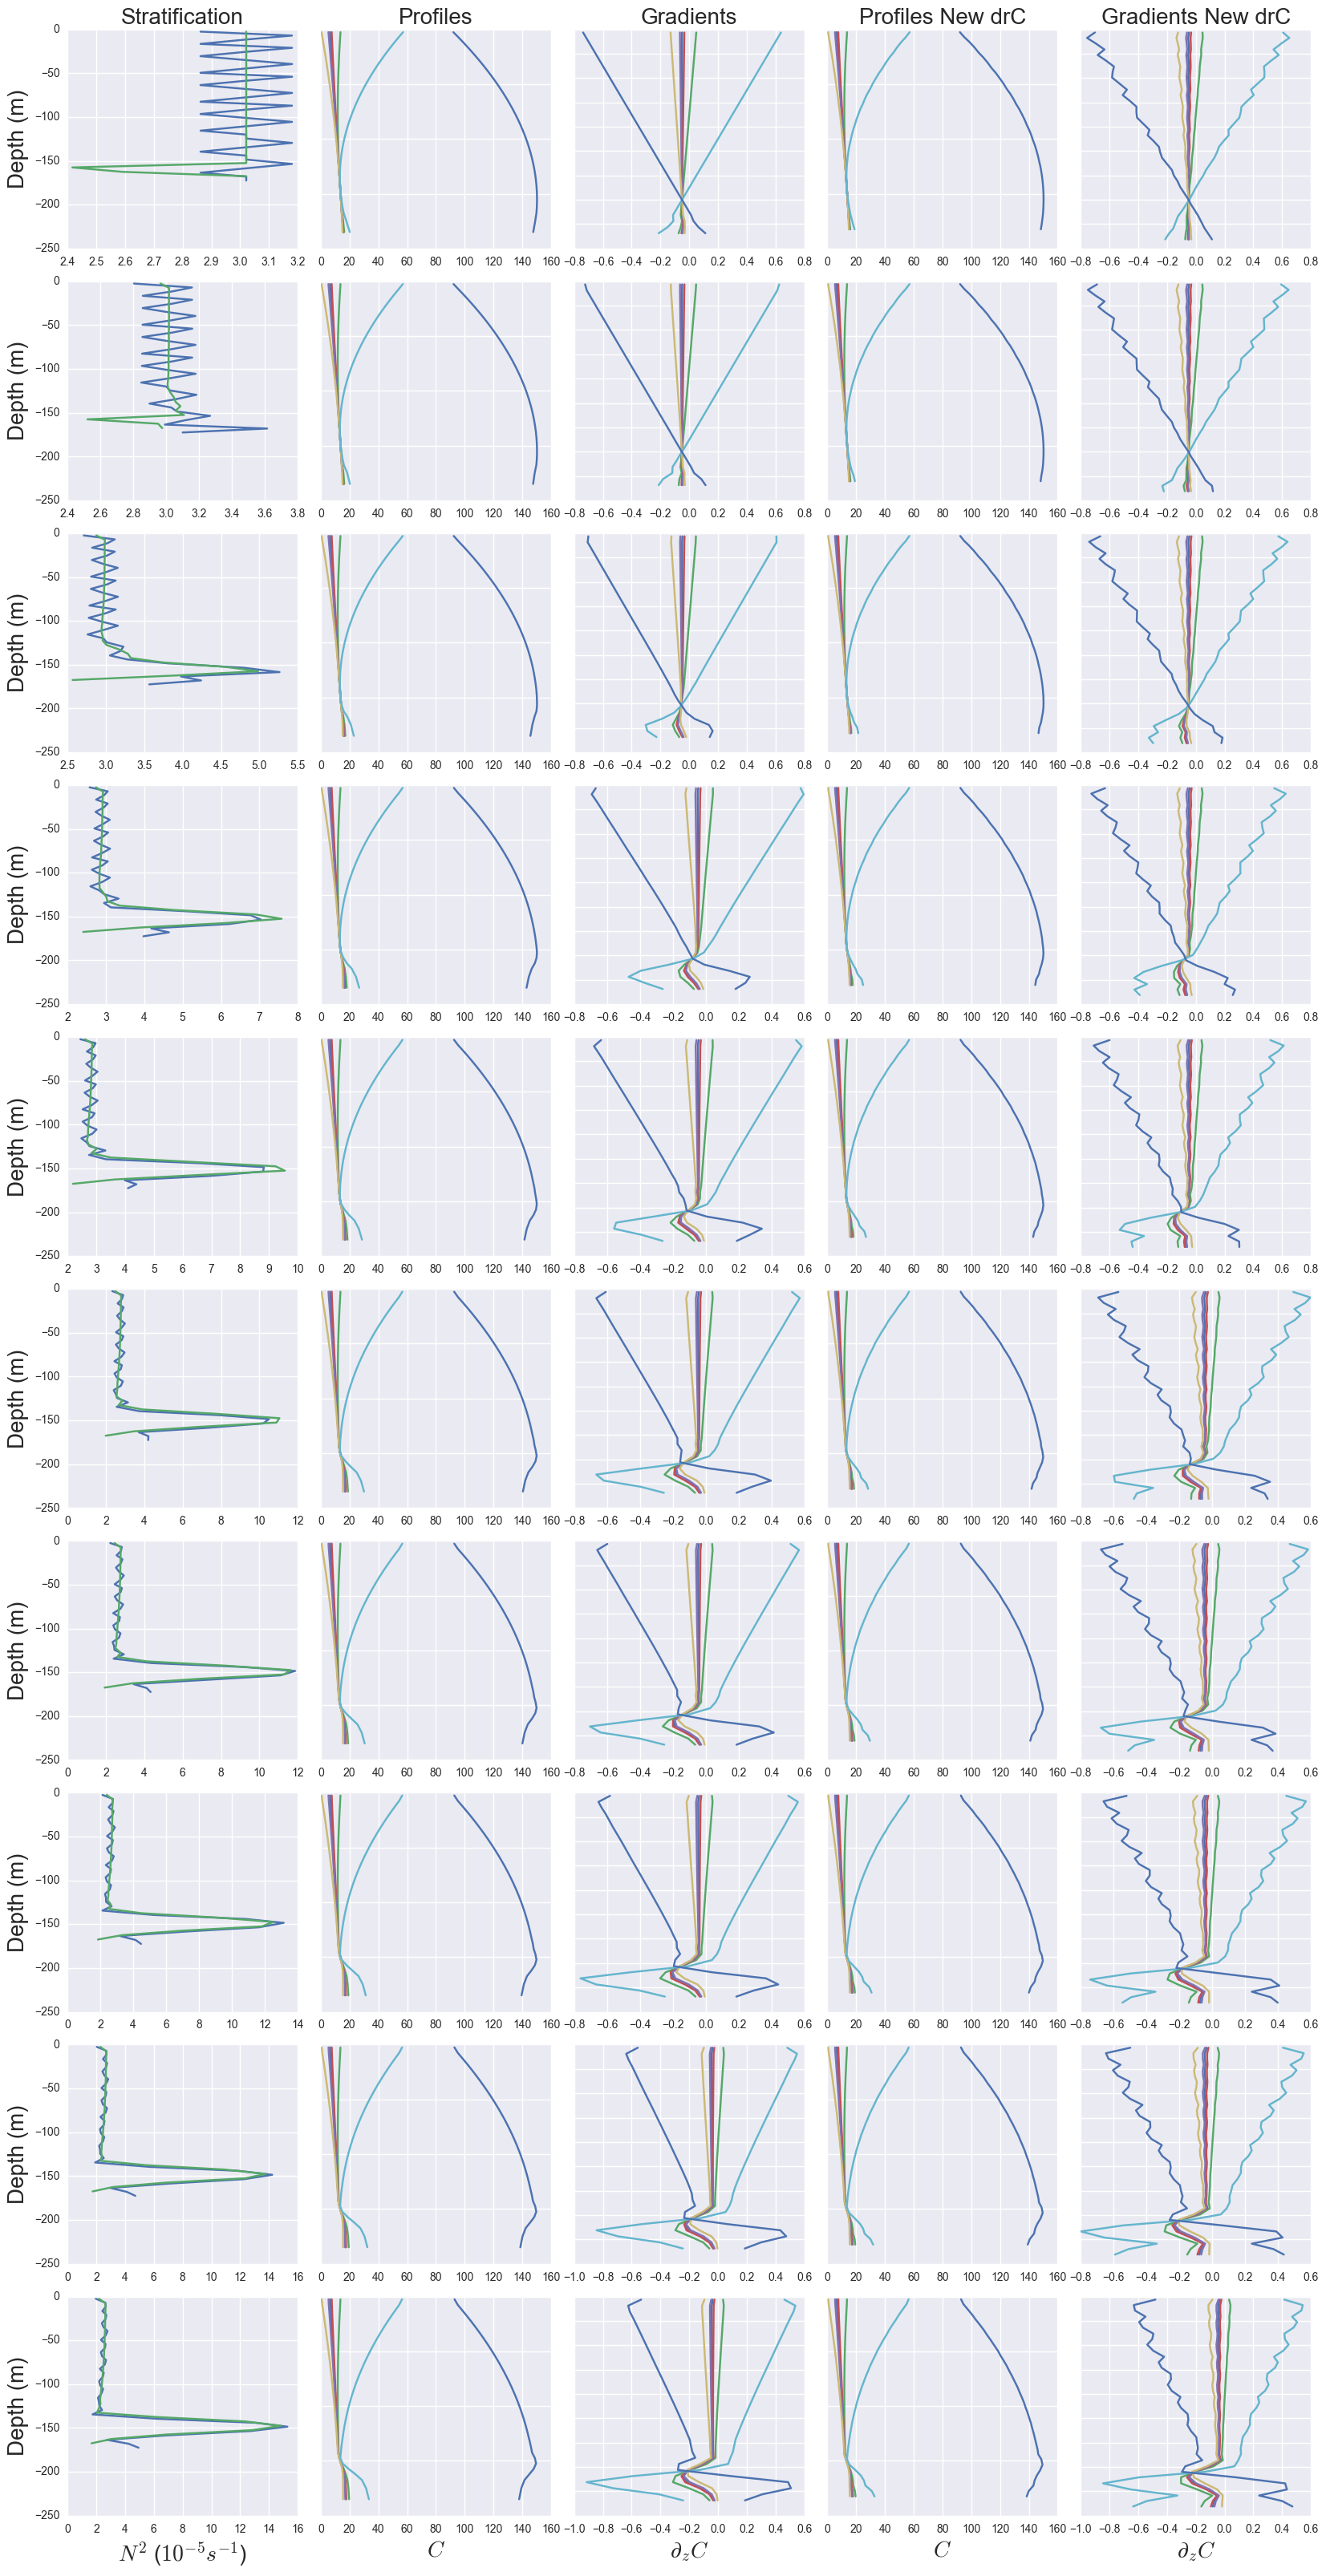

In [8]:
tracers_para = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
tracers_Smooth = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']

times = [0,2,4,6,8,10,12,14,16,18]
nt = len(times)

fig = plt.figure(figsize=(20,40)) 
gs = gspec.GridSpec(nt, 5, hspace=0.15, wspace=0.1)


for trac in tracers_para:
    Tr = get_profile(PtracParaDS,trac,times,mask,yi,xi)
    dTr = calc_dTrdz(Tr,drC)
    print('Parabolic:', trac, Tr[0,29], Tr[5,25] , dTr[0,30])     
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,1]).plot(Tr[tt,:],depth)
        plt.subplot(gs[tt,2]).plot(dTr[tt,:],depth[:-2])
        #plt.subplot(gs[tt,1]).set_ylim(-250,0)
        #plt.subplot(gs[tt,2]).set_ylim(-250,0)
        #plt.subplot(gs[tt,2]).set_xlim(-1.5,1)
        #plt.subplot(gs[tt,1]).set_xlim(0,160)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
        
for trac in tracers_Smooth:
    Tr = get_profile(PtracSmoothDS,trac,times,mask_s,yi,xi)
    dTr = calc_dTrdz(Tr,drC_s)
    print('Smooth:', trac,Tr[0,29],Tr[5,25], dTr[0,30])    
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,3]).plot(Tr[tt,:],depth_s)
        plt.subplot(gs[tt,4]).plot(dTr[tt,:],depth_s[:-2],)
        #plt.subplot(gs[tt,3]).set_ylim(-250,0)
        #plt.subplot(gs[tt,4]).set_ylim(-250,0)
        #plt.subplot(gs[tt,3]).set_xlim(0,280)
        #plt.subplot(gs[tt,4]).set_xlim(-1.3,3)
        plt.subplot(gs[tt,3]).set_yticklabels([])
        plt.subplot(gs[tt,4]).set_yticklabels([])
       
    
N2_Smooth = calc_N2(StateSmoothDS,times,mask_s,drC_s,yi,xi)
N2_para = calc_N2(StateParaDS,times,mask,drC,yi,xi)
        
for tt in range(nt):
    plt.subplot(gs[tt,0]).plot((N2_Smooth[tt,:])*1E5,depth_s[:-2],)
    plt.subplot(gs[tt,0]).plot((N2_para[tt,:])*1E5,depth[:-2],)

xlabels = ['$N^2$ ($10^{-5} s^{-1}$)','$C$','$\partial_zC$','$C$','$\partial_zC$']
for plot, xlabel in zip(range(5),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Stratification','Profiles','Gradients','Profiles New drC','Gradients New drC']
for plot, title in zip(range(5),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    plt.subplot(gs[tt,0]).set_ylim(-250,0)
    #plt.subplot(gs[tt,0]).set_xlim(0,15)
    




Smooth: Tr1 13.2250003815 11.671046257 -0.05
Smooth: Tr2 13.2358903885 12.1553401947 -0.0525199890137
Smooth: Tr3 13.2267847061 11.7504167557 -0.0504130363464
Smooth: Tr4 13.2233963013 11.5997476578 -0.0496290206909
Smooth: Tr5 13.2162275314 11.2809200287 -0.0479700088501
Smooth: Tr6 13.3006248474 15.0342655182 -0.0675000190735
Smooth: Tr7 149.649368286 144.807891846 -0.0324996948242


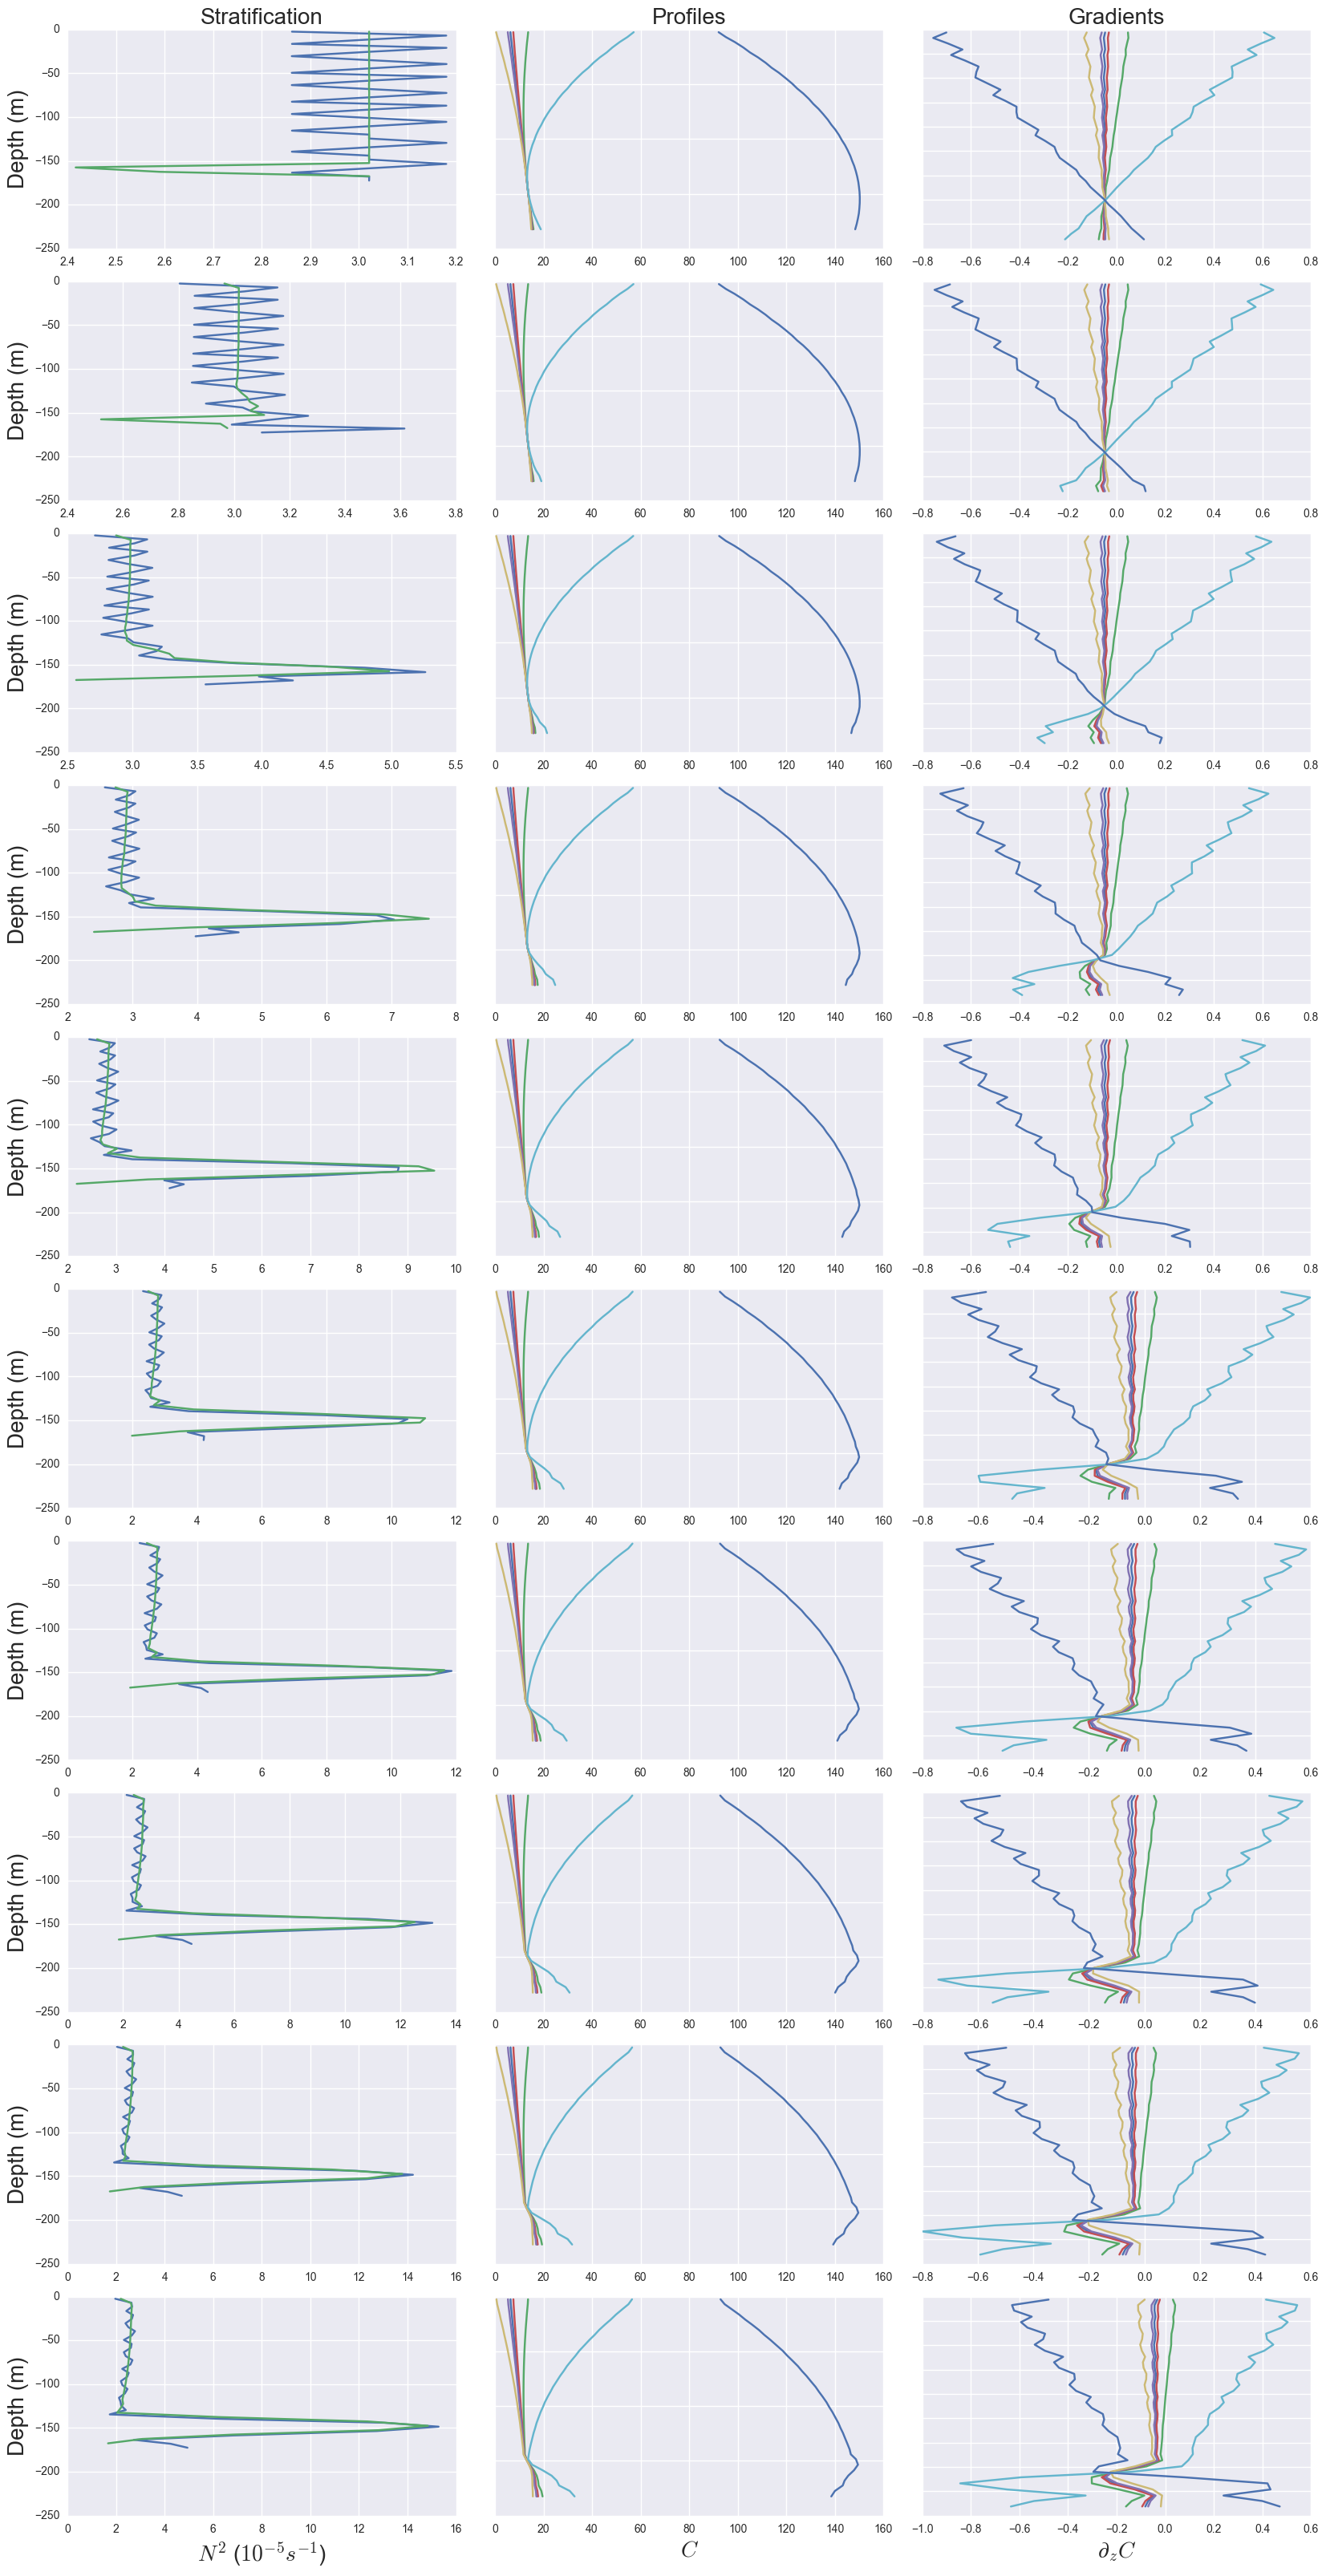

In [10]:
tracers_Smooth = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']

times = [0,2,4,6,8,10,12,14,16,18]
nt = len(times)

fig = plt.figure(figsize=(20,40)) 
gs = gspec.GridSpec(nt, 3, hspace=0.15, wspace=0.1)
      
for trac in tracers_Smooth:
    Tr = get_profile(PtracSmoothDS,trac,times,mask_s,yi,xi)
    dTr = calc_dTrdz(Tr,drC_s)
    print('Smooth:', trac,Tr[0,29],Tr[5,25], dTr[0,30])    
    for tt,time in zip(range(nt),times):
        plt.subplot(gs[tt,1]).plot(Tr[tt,:],depth_s)
        plt.subplot(gs[tt,2]).plot(dTr[tt,:],depth_s[:-2],)
        #plt.subplot(gs[tt,3]).set_ylim(-250,0)
        #plt.subplot(gs[tt,4]).set_ylim(-250,0)
        #plt.subplot(gs[tt,3]).set_xlim(0,280)
        #plt.subplot(gs[tt,4]).set_xlim(-1.3,3)
        plt.subplot(gs[tt,1]).set_yticklabels([])
        plt.subplot(gs[tt,2]).set_yticklabels([])
       
    
N2_Smooth = calc_N2(StateSmoothDS,times,mask_s,drC_s,yi,xi)
N2_para = calc_N2(StateParaDS,times,mask,drC,yi,xi)
        
for tt in range(nt):
    plt.subplot(gs[tt,0]).plot((N2_Smooth[tt,:])*1E5,depth_s[:-2],)
    plt.subplot(gs[tt,0]).plot((N2_para[tt,:])*1E5,depth[:-2],)

xlabels = ['$N^2$ ($10^{-5} s^{-1}$)','$C$','$\partial_zC$','$C$','$\partial_zC$']
for plot, xlabel in zip(range(3),xlabels):
    plt.subplot(gs[nt-1,plot]).set_xlabel(xlabel,fontsize=20)

titles = ['Stratification','Profiles','Gradients','Profiles New drC','Gradients New drC']
for plot, title in zip(range(3),titles):
    plt.subplot(gs[0,plot]).set_title(title,fontsize=20)

for tt in range(nt):
    plt.subplot(gs[tt,0]).set_ylabel('Depth (m)',fontsize=20)
    plt.subplot(gs[tt,0]).set_ylim(-250,0)
    #plt.subplot(gs[tt,0]).set_xlim(0,15)
    




It's really noisy, not surprised, there were many jumps between 4m and 5m spacing. I need to do a more homogeneous one?